In [1]:
%load_ext autoreload
%autoreload 2

from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
import os
import sys
sys.path.append('../..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.manage_orderbooks import *
from helper.evaluation import evaluate, plot_evaluation_costs
from helper.general_helpers import add_features_to_orderbooks, load_and_preprocess_historyfiles, discretize_hist_feature

from agents.RL_Agent_Base import RLAgent_Base
from agents.BatchTree_Agent import RLAgent_BatchTree
from agents.QTable_Agent import QTable_Agent

#### Load pretrained Agents

In [33]:
agent_files = {
    'currBid': '../trainedAgents/shortterm_1611_currBid/QTable_1611_T4_I8_VolTime.json',
    'currBid_mSpread': '../trainedAgents/shortterm_1611_currBid/retrained/QTable_1611_T4_I8_VolTime_marketPrice_spread.json',
    'currBid_spread':  '../trainedAgents/shortterm_1611_currBid/retrained/QTable_1611_T4_I8_VolTime_spread.json',
    'currAsk': '../trainedAgents/shortterm_1611_currAsk/QTable_1611_T4_I8_VolTime.json',
    'currAsk_mSpread': '../trainedAgents/shortterm_1611_currAsk/retrained/QTable_1611_T4_I8_VolTime_marketPrice_spread.json',
    'currAsk_spread': '../trainedAgents/shortterm_1611_currAsk/retrained/QTable_1611_T4_I8_VolTime_spread.json',
}

print(agent_files)

{'currBid': '../trainedAgents/shortterm_1611_currBid/QTable_1611_T4_I8_VolTime.json', 'currBid_mSpread': '../trainedAgents/shortterm_1611_currBid/retrained/QTable_1611_T4_I8_VolTime_marketPrice_spread.json', 'currBid_spread': '../trainedAgents/shortterm_1611_currBid/retrained/QTable_1611_T4_I8_VolTime_spread.json', 'currAsk': '../trainedAgents/shortterm_1611_currAsk/QTable_1611_T4_I8_VolTime.json', 'currAsk_mSpread': '../trainedAgents/shortterm_1611_currAsk/retrained/QTable_1611_T4_I8_VolTime_marketPrice_spread.json', 'currAsk_spread': '../trainedAgents/shortterm_1611_currAsk/retrained/QTable_1611_T4_I8_VolTime_spread.json'}


In [35]:
agent_collection = {}
try:
    agent_collection
except NameError:
    agent_collection = {}
    
for e, key in enumerate(agent_files.keys()):
    elem = agent_files[key]
    folder, name = os.path.split(agent_files[key])
    
    name = name[:-5]
    print(name)
    agent = RLAgent_Base.load(agent_name=name, path=folder, ignore_samples=True)
    # agent.heatmap_Q()
    print(agent)
    agent_collection[key] = agent
    
print("agent_collection contains {} elements:\n{}".format(len(agent_collection), list(agent_collection.keys())))


QTable_1611_T4_I8_VolTime
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>, Name: 'QTable_1611_T4_I8_VolTime', state_variables: '['volume', 'time']'
QTable_1611_T4_I8_VolTime_marketPrice_spread
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>, Name: 'QTable_1611_T4_I8_VolTime_marketPrice_spread', state_variables: '['volume', 'time', 'marketPrice_spread_disc3']'
QTable_1611_T4_I8_VolTime_spread
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>, Name: 'QTable_1611_T4_I8_VolTime_spread', state_variables: '['volume', 'time', 'spread_disc3']'
QTable_1611_T4_I8_VolTime
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>, Name: 'QTable_1611_T4_I8_VolTime', state_variables: '['volume', 'time']'
QTable_1611_T4_I8_VolTime_marketPrice_spread
RL-Type: <class 'agents.QTable_Agent.QTable_Agent'>, Name: 'QTable_1611_T4_I8_VolTime_marketPrice_spread', state_variables: '['volume', 'time', 'marketPrice_spread_disc3']'
QTable_1611_T4_I8_VolTime_spread
RL-Type: <class 'agents.QTable_Agent.QTable_A

### Load data

In [7]:
# histfiles = [
#     "../../../../data/history/history_2016-11_USDT_BTC.csv",
#     "../../../../data/history/history_2016-12_USDT_BTC.csv",
#     "../../../../data/history/history_2017-01_USDT_BTC.csv",
#     "../../../../data/history/history_2017-02_USDT_BTC.csv",
# ]
# 
# hist = load_and_preprocess_historyfiles(histfiles)
# 
# hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
# hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
# hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
# hist['spread_disc'] = pd.cut(hist.spread, bins=[0, 1, 2, np.inf], labels=False)
# # display(hist.iloc[1021:1025,:])

In [36]:
variables = []
for ag in agent_collection.values():
    print(ag.agent_name, ag.state_variables)
    variables += ag.state_variables
variables = set(variables)
variables.remove('time')
variables.remove('volume')
#variables = [v[:-5] for v in variables]
variables

QTable_1611_T4_I8_VolTime ['volume', 'time']
QTable_1611_T4_I8_VolTime_marketPrice_spread ['volume', 'time', 'marketPrice_spread_disc3']
QTable_1611_T4_I8_VolTime_spread ['volume', 'time', 'spread_disc3']
QTable_1611_T4_I8_VolTime ['volume', 'time']
QTable_1611_T4_I8_VolTime_marketPrice_spread ['volume', 'time', 'marketPrice_spread_disc3']
QTable_1611_T4_I8_VolTime_spread ['volume', 'time', 'spread_disc3']


{'marketPrice_spread_disc3', 'spread_disc3'}

In [37]:
hist = pd.read_csv('../ob_features70000_1611_1705.csv', index_col=0, parse_dates=[0])
variables_disc = [(v[:-6], v[-1]) for v in variables if '_disc' in v]
print("variables_disc", variables_disc)

for elem in variables_disc:
    feat = elem[0]
    bins = int(elem[1])
    print('discretize', feat, bins)
    hist = discretize_hist_feature(hist, feature=feat, test_start_date='2016-12-01', bins=bins)
display(hist.head(3))

variables_disc [('spread', '3'), ('marketPrice_spread', '3')]
discretize spread 3
discretize marketPrice_spread 3


,ask,bid,center,center_orig,future_center15,future_center5,future_center60,marketPrice_buy_worst,marketPrice_imbalance,marketPrice_sell_worst,...,maxSlip_imbalance,maxSlip_sell,ob_direction,orderPriceRatio,sharecount_buy,sharecount_imbalance,sharecount_sell,sharecount_spread,spread,spread_disc3
2016-11-08 10:00:00,1.000320,0.999680,1.0,705.225474,-0.0007,-0.0009,0.0001,1.013860,1.371168,0.980995,...,0.729305,0.019005,1.000147,99.259035,98.346757,0.018974,100.212814,1.866057,0.000640,0.0
2016-11-08 10:01:00,1.001171,0.998829,1.0,704.625570,0.0001,-0.0000,0.0010,1.014723,1.198463,0.982355,...,0.834402,0.017645,1.000147,99.343542,98.386851,0.017872,100.145263,1.758412,0.002342,1.0
2016-11-08 10:02:00,1.001171,0.998829,1.0,704.625569,0.0006,-0.0001,0.0010,1.014723,1.198463,0.982355,...,0.834402,0.017645,1.000147,99.343542,98.397131,0.017773,100.145963,1.748832,0.002342,1.0


In [ ]:
data_mini = pickle.load( open( "../cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
num_cores = multiprocessing.cpu_count()
data_mini = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(
    orderbooks=window, 
    hist=hist,
    features=variables) 
                                                   for window in data_mini[:])
print(len(data_mini), len(data_mini[0]))
data = data_mini

In [32]:
data_nov = pickle.load( open( '../../cached_windows_60mins/obs_2016-11_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_nov))
print(data_nov[0][0])
num_cores = multiprocessing.cpu_count()
data_nov = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(
    orderbooks=window, 
    hist=hist,
    features=variables) 
                                                  for window in data_nov[:])
print(len(data_nov))
data_nov[0][0]

541
OrderbookContainer from 2016-11-08T10:00 (factor: 1.0)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    6.6s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:    8.9s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   16.2s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   20.1s
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:   25.0s
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:   29.2s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   33.4s
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:   39.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   44.5s
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed:   52.3s
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed:   58.1s
[Parallel(n_jobs=24)]: Done 217 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 265 tasks      | elapsed:  1.4min
[Paralle

541


OrderbookContainer from 2016-11-08T10:00 (factor: 1.0)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'
  -spread_disc3: 0.0
  -marketPrice_spread_disc3: 2.0
  -direction: 1.000147010565701
  -direction_disc: 0.0

In [47]:
data_dec = pickle.load( open( '../../cached_windows_60mins/obs_2016-12_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_dec))
print(data_dec[0][0])
num_cores = multiprocessing.cpu_count()
data_dec = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(
    orderbooks=window, 
    hist=hist,
    features=variables) 
                                                 for window in data_dec[:])
print(len(data_dec))
data_dec[0][0]

743
OrderbookContainer from 2016-12-01T00:00 (factor: 1.0)
  185 bids (best: 738.1524754)
  247 asks (best: 741.0)
price: 739.5753240682233
  kind: 'orderbook'


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:   14.1s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   18.5s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   21.8s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   24.9s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   28.9s
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:   32.4s
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:   36.7s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   49.3s
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:   57.8s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:  1.0min
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 217 tasks      | elapsed:  1.4min
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:  1.5min
[Parallel(n_jobs=24)]: Done 265 tasks      | elapsed:  1.6min
[Paralle

743


OrderbookContainer from 2016-12-01T00:00 (factor: 1.0)
  185 bids (best: 738.1524754)
  247 asks (best: 741.0)
price: 739.5753240682233
  kind: 'orderbook'
  -spread_disc3: 2.0
  -marketPrice_spread_disc3: 1.0
  -direction: 1.0006989439452016
  -direction_disc: 0.0

In [ ]:
data_apr = pickle.load( open( "../../cached_windows_60mins_V200/obs_2017-04_USDT_BTC_maxVol200.p", "rb" ) )
print("data_may", len(data_may))
data_apr = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(
    orderbooks=window, 
    hist=hist,
    features=variables) 
                                                 for window in data_apr[:96])

In [ ]:
# data_may = pickle.load( open( "../../cached_windows_60mins_V200/obs_2017-05_USDT_BTC_maxVol200.p", "rb" ) )
print("data_may", len(data_may))
data_may = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(
    orderbooks=window, 
    hist=hist,
    features=variables) 
                                                 for window in data_may)

### Evaluate

In [59]:
data = data_nov[:]
baseline = list(agent_collection.keys())[0]
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5, 'MarketOrder'],
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.mean())
display(slippage.mean() / slippage["5"].mean())
plot_evaluation_costs(slippage, hline=baseline, showfliers=False)

Start parallel evalutions of 8 strategies over 541 tradingperiods. (num_cores=24)


100%|██████████| 6/6 [00:08<00:00,  1.51s/it]

100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

 67%|██████▋   | 4/6 [00:06<00:03,  1.54s/it]

Couldn't trade 2016-11-13T07:01: 'Can't handle trade. Orderbookvolume exceeded, must fulfill abs(70000) < 69963.07406530257'


 67%|██████▋   | 4/6 [00:04<00:02,  1.12s/it]

Couldn't trade 2016-11-13T15:01: 'Can't handle trade. Orderbookvolume exceeded, must fulfill abs(70000) < 69453.50223443462'


 50%|█████     | 3/6 [00:05<00:05,  1.86s/it]

Couldn't trade 2016-11-13T16:01: 'Can't handle trade. Orderbookvolume exceeded, must fulfill abs(70000) < 69904.86970745209'


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

100%|██████████| 6/6 [00:11<00:00,  1.98s/it]

100%|██████████| 6/6 [00:11<00:00,  1.91s/it]

100%|██████████| 6/6 [00:11<00:00,  1.93s/it]

100%|██████████| 6/6 [00:06<00:00,  1.17s/it]

100%|██████████| 6/6 [00:12<00:00,  2.01s/it]

100%|██████████| 6/6 [00:10<00:00,  1.79s/it]

100%|██████████| 6/6 [00:11<00:00,  1.87s/it]

100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]

100%|██████████| 6/6 [00:09<00:00,  1.68s/it]

100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

100%|██████████| 6/6 [00:12<00:00,  2.06s/it]

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

100%|██████████| 6/6 [00:12<00:00,  2.07s/it]

100%|██████████| 6/6 [00:12<00:00,  2.07s/it]

100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


100%|██████████| 6/6 [00:09<00:00,  1.44s/it]
[Parallel(n_jobs=24)]: Done 541 out of 541 | elapsed:  4.4min finished


done


currBid            220.188105
currBid_mSpread    218.713822
currBid_spread     215.706260
currAsk            214.001907
currAsk_mSpread    214.527016
currAsk_spread     215.384570
5                  237.746014
MarketOrder        737.579678
dtype: float64

KeyError: '2'

,0,perf
currBid,220.19,0.93
currBid_mSpread,218.71,0.92
currBid_spread,215.71,0.91
currAsk,214.00,0.90
currAsk_mSpread,214.53,0.90
currAsk_spread,215.38,0.91
5,237.75,1.00
MarketOrder,737.58,3.10


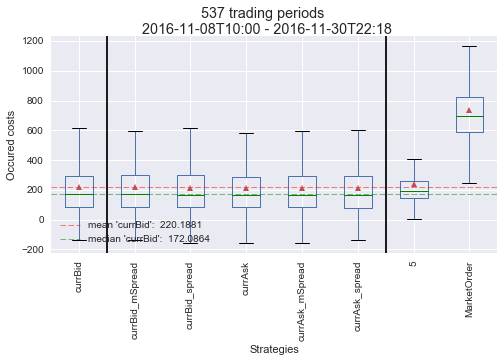

In [67]:
perf = pd.DataFrame(slippage.mean())
perf['perf'] = slippage.mean() / slippage["5"].mean()
perf = round(perf, 2)
display(perf)

plot_evaluation_costs(slippage, hline=baseline, showfliers=False)

In [53]:
plot_evaluation_costs(slippage.iloc[:,:-1], vlines=[3,6], hline='min', showfliers=False, ylim=(75,325), outfile='performance_limitBase_nov.pdf')

Saved figure to 'performance_limitBase_nov.pdf'


In [ ]:
data = data_dec[:]
baseline = list(agent_collection.keys())[0]
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    #evaluate_actions=[2, 3, 4, 5],  # , 'MarketOrder'],
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.mean())
plot_evaluation_costs(slippage, hline=baseline, showfliers=False)

In [ ]:
plot_evaluation_costs(slippage.iloc[:,:-4], hline=baseline, showfliers=False, outfile='performance_limitBase_dec.pdf')
print(pd.DataFrame(slippage.iloc[:,:-4].mean()).to_latex())

In [ ]:
data = data_may[:96]
baseline = list(agent_collection.keys())[0]
costs, slippage = evaluate(
    testdata=data,
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5],  # , 'MarketOrder'],
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.mean())
plot_evaluation_costs(slippage, hline=baseline, showfliers=False)

In [ ]:
slippage.mean()

In [ ]:
plot_evaluation_costs(costs, hline=baseline, showfliers=False, ylim=(100,300))

## Check for best S&L Strategy over training data (Nov16-Jan17)

In [ ]:
costs_list_train = pd.concat([
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-11_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-12_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2017-01_USDT_BTC.csv", index_col=0)])

plot_experiment_results(costs_list_train, name='Trainset (USDT-BTC)', ylim=(-1.5, 1.5))

mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))

### Compare strategies on Testset (Feb2017)

In [ ]:
T = ql.T
V = ql.V
period_length = ql.period_length
print("V={}, T={}, period_length={}".format(V, T, period_length))

costs_list = run_Q(V=100, H=T*period_length, T=T, ql=ql,
                   episode_windows=episodes_test[:5], actions=actions)

In [ ]:
plot_experiment_results(costs_list, name='Trainset (USDT-BTC)')  #, ylim=(-1.5, 1.5))
mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))